##Librerias

In [ ]:
# Instalacion de librerías para web scraping y manipulación de datos
!pip install pandas selenium webdriver-manager
!pip install app-store-scraper # Para reseñas de la App Store de Apple
!pip install google-play-scraper # Para reseñas de Google Play

# Instalacion de librerías para análisis de sentimiento y NLP
!pip install sentiment-analysis-spanish
!pip install matplotlib seaborn wordcloud
!pip install emoji



INFO: pip is looking at multiple versions of requests to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
app-store-scraper 0.3.5 requires requests==2.23.0, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatib

In [ ]:
!pip uninstall -y urllib3 requests six transformers torch
!pip install requests==2.32.3 urllib3==2.2.3 six==1.16.0 --quiet
!pip install torch==2.8.0 transformers==4.46.2 tqdm --quiet


Found existing installation: urllib3 1.25.11
Uninstalling urllib3-1.25.11:
  Successfully uninstalled urllib3-1.25.11
Found existing installation: requests 2.23.0
Uninstalling requests-2.23.0:
  Successfully uninstalled requests-2.23.0
Found existing installation: six 1.17.0
Uninstalling six-1.17.0:
  Successfully uninstalled six-1.17.0
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.21 requires torch, which is not installed.
fastai 2.8.5 requires 

In [ ]:
import os, sys
os.kill(os.getpid(), 9)


## Fase 1: Recolección de Datos (Web Scraping)

In [ ]:
# 1. Importar las librerías necesarias
import pandas as pd
from google_play_scraper import reviews
from google_play_scraper import Sort
from urllib.parse import urlparse, parse_qs

# --- CONFIGURACIÓN ---
nombre_archivo_excel = 'ListaApps.xlsx'      # Nombre del archivo Excel
nombre_columna_url = 'url_google_play'        # Columna con las URLs de las apps
nombre_columna_app = 'nombre_de_la_app'       # Columna con los nombres de las apps
limite_reseñas = 5000                         # Número máximo de reseñas a descargar
# --------------------


# 2. Cargar tu archivo de Excel en un DataFrame de pandas
try:
    df_apps = pd.read_excel(nombre_archivo_excel)
    print("✅ ¡Excel cargado correctamente!")
    print(df_apps.head())
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{nombre_archivo_excel}'.")
    exit()


# 3. Función para extraer el ID de la aplicación desde la URL
def extraer_id_de_url(url):
    """Extrae el ID de una app desde su URL de Google Play."""
    if not isinstance(url, str):
        return None
    try:
        parsed_url = urlparse(url)
        query_params = parse_qs(parsed_url.query)
        return query_params['id'][0]
    except (KeyError, IndexError):
        print(f"⚠️ Advertencia: No se pudo extraer el ID de la URL: {url}")
        return None


# 4. Crear columna con los IDs
df_apps['app_id'] = df_apps[nombre_columna_url].apply(extraer_id_de_url)
df_apps.dropna(subset=['app_id'], inplace=True)

print("\n📱 DataFrame con IDs extraídos:")
print(df_apps.head())


# 5. Descargar las reseñas más recientes de cada app
print("\n--- Iniciando la descarga de reseñas ---")

for index, fila in df_apps.iterrows():
    app_nombre = fila[nombre_columna_app]
    app_id = fila['app_id']

    print(f"\nDescargando reseñas más recientes para: {app_nombre} (ID: {app_id})")

    try:
        # Usamos 'reviews' en lugar de 'reviews_all'
        resultado, _ = reviews(
            app_id,
            lang='es',               # Idioma español
            country='co',            # País Colombia
            sort=Sort.NEWEST,        # Ordenar por las más recientes
            count=limite_reseñas     # Limitar a 5000 reseñas
        )

        # Convertir a DataFrame
        df_reviews = pd.DataFrame(resultado)

        # Guardar en CSV
        nombre_archivo_csv = f'reseñas_{app_nombre.replace(" ", "_")}.csv'
        df_reviews.to_csv(nombre_archivo_csv, index=False)
        print(f"✅ Se guardaron {len(df_reviews)} reseñas en '{nombre_archivo_csv}'")

    except Exception as e:
        print(f"❌ Error al descargar reseñas de {app_nombre}: {e}")

print("\n--- Proceso de descarga finalizado ---")


✅ ¡Excel cargado correctamente!
         nombre_de_la_app                                    url_google_play
0     Nequi (Bancolombia)  https://play.google.com/store/apps/details?id=...
1  Daviplata (Davivienda)  https://play.google.com/store/apps/details?id=...
2                   Movii  https://play.google.com/store/apps/details?id=...
3               Lulo Bank  https://play.google.com/store/apps/details?id=...
4         Nubank Colombia  https://play.google.com/store/apps/details?id=...

📱 DataFrame con IDs extraídos:
         nombre_de_la_app                                    url_google_play  \
0     Nequi (Bancolombia)  https://play.google.com/store/apps/details?id=...   
1  Daviplata (Davivienda)  https://play.google.com/store/apps/details?id=...   
2                   Movii  https://play.google.com/store/apps/details?id=...   
3               Lulo Bank  https://play.google.com/store/apps/details?id=...   
4         Nubank Colombia  https://play.google.com/store/apps/details?id=.

## Fase 2: Unificación de reseñas y eliminación de columnas innecesarias

In [ ]:
import glob # Librería para buscar archivos por patrón

print("--- Iniciando la unificación de archivos CSV ---")

# 1. Definir el patrón de búsqueda
patron_archivos = 'reseñas_*.csv'

# 2. Usar 'glob' para encontrar todos los archivos que coincidan
archivos_csv_encontrados = glob.glob(patron_archivos)

if not archivos_csv_encontrados:
    print(f"❌ Error: No se encontró ningún archivo con el patrón '{patron_archivos}'.")
    print("Asegúrate de que el primer script se haya ejecutado y generado los archivos.")
else:
    print(f"✅ Se encontraron {len(archivos_csv_encontrados)} archivos para unificar.")

    # 3. Leer cada archivo CSV y guardarlo en una lista de DataFrames
    lista_de_dataframes = []
    for archivo in archivos_csv_encontrados:
        try:
            df_temp = pd.read_csv(archivo)

            # Creamos la columna con el nombre de la app a partir del nombre del archivo
            # Como el formato es 'reseñas_Nombre_De_La_App.csv'

            # 1. Quitamos el prefijo 'reseñas_' y el sufijo '.csv'
            nombre_base = archivo[len('reseñas_'):-len('.csv')]

            # 2. Revertimos los '_' a espacios
            nombre_app_limpio = nombre_base.replace("_", " ")

            # 3. Creamos la nueva columna
            df_temp['nombre_app'] = nombre_app_limpio
            # ------------------------

            lista_de_dataframes.append(df_temp)
            print(f"  ...cargando {archivo} ({len(df_temp)} filas) -> App: {nombre_app_limpio}")

        except Exception as e:
            print(f"⚠️ Advertencia: No se pudo leer el archivo '{archivo}'. Error: {e}")

    # 4. Combinar (concatenar) todos los DataFrames de la lista en uno solo
    if lista_de_dataframes:
        # pd.concat une todos los dataframes
        # ignore_index=True crea un índice nuevo y limpio para el dataframe final
        df = pd.concat(lista_de_dataframes, ignore_index=True)

        print(f"\n ¡Unificación completa! El DataFrame 'df' tiene {len(df)} filas en total.")

        # 5. Guardar el DataFrame unificado en un archivo Excel
        nombre_excel_final = 'final_google_store.xlsx'
        try:
            # Usamos index=False para no guardar el índice de pandas en el Excel
            df.to_excel(nombre_excel_final, index=False)
            print(f"✅ DataFrame unificado guardado exitosamente en '{nombre_excel_final}'")

            # 6. Mostrar un vistazo del DataFrame final (variable 'df')
            print("\n--- Primeras 5 filas del DataFrame 'df' unificado (con la nueva columna) ---")
            print(df.head())

            # Mostrar también las columnas para verificar 'nombre_app'
            print("\nColumnas del DataFrame final:")
            print(df.columns)

        except Exception as e:
            print(f"❌ Error al guardar el archivo Excel: {e}")
            print("Verifica si tienes los permisos necesarios o si el archivo ya está abierto.")
    else:
        print("❌ Error: No se pudo cargar ningún DataFrame para unificar.")

--- Iniciando la unificación de archivos CSV ---
✅ Se encontraron 11 archivos para unificar.
  ...cargando reseñas_Daviplata_(Davivienda).csv (5000 filas) -> App: Daviplata (Davivienda)
  ...cargando reseñas_Tpaga.csv (5000 filas) -> App: Tpaga
  ...cargando reseñas_Movii.csv (5000 filas) -> App: Movii
  ...cargando reseñas_Nubank_Colombia.csv (5000 filas) -> App: Nubank Colombia
  ...cargando reseñas_Addi.csv (5000 filas) -> App: Addi
  ...cargando reseñas_Lulo_Bank.csv (5000 filas) -> App: Lulo Bank
  ...cargando reseñas_Coink.csv (1081 filas) -> App: Coink
  ...cargando reseñas_Powwi.csv (1121 filas) -> App: Powwi
  ...cargando reseñas_Nequi_(Bancolombia).csv (5000 filas) -> App: Nequi (Bancolombia)
  ...cargando reseñas_Dale!_(Grupo_Aval).csv (5000 filas) -> App: Dale! (Grupo Aval)
  ...cargando reseñas_Ualá_Colombia.csv (5000 filas) -> App: Ualá Colombia

 ¡Unificación completa! El DataFrame 'df' tiene 47202 filas en total.
✅ DataFrame unificado guardado exitosamente en 'final_goo

In [ ]:
#Se borran las columnas que no se usarán

columnas_a_borrar = [
    'userName',
    'reviewId',
    'userImage',
    'thumbsUpCount',
    'reviewCreatedVersion',
    'replyContent',
    'repliedAt',
    'appVersion'
]

df = df.drop(columns=columnas_a_borrar, errors='ignore')


In [ ]:
df.head()

,content,score,at,nombre_app
0,buenas tardes no me deja abrir Nanocrédito me ...,5,2025-11-05 20:07:48,Daviplata (Davivienda)
1,desde la actualización no puedo utilizar mi saldo,2,2025-11-05 19:09:16,Daviplata (Davivienda)
2,Es un problema ingresar. Me tiene cansado tene...,2,2025-11-05 18:33:41,Daviplata (Davivienda)
3,Es buena pero necesito cambiar la clave porque...,5,2025-11-05 18:00:47,Daviplata (Davivienda)
4,por qué los montos mínimos ahora solo se puede...,1,2025-11-05 17:59:32,Daviplata (Davivienda)


In [ ]:
#Aplicamos formato a la columna 'at' (fecha de la reseña)

# 1. Asegurarse de que la columna 'at' sea del tipo datetime
df['at'] = pd.to_datetime(df['at'])

# 2. Normalizar la fecha (eliminar la hora)
#    .dt.normalize() establece la hora, minutos y segundos a cero.
#    Crearemos una nueva columna para mantener el dato original para backup.
df['fecha'] = df['at'].dt.normalize()

# 3. (Opcional) Si se quiere la fecha como un string en formato D/M/A
#     útil solo para visualización final, no para cálculos.
# df['fecha_texto'] = df['at'].dt.strftime('%d/%m/%Y')

# --- Verificación ---
print("Comparación de la columna original 'at' y la nueva 'fecha':")
print(df[['at', 'fecha']].head())



Comparación de la columna original 'at' y la nueva 'fecha':
                   at      fecha
0 2025-11-05 20:07:48 2025-11-05
1 2025-11-05 19:09:16 2025-11-05
2 2025-11-05 18:33:41 2025-11-05
3 2025-11-05 18:00:47 2025-11-05
4 2025-11-05 17:59:32 2025-11-05


## Fase 3: Limpieza y Preprocesamiento de Datos

In [ ]:

import re
import emoji
import chardet


# 1 print(df.head())

# 2️ Función para corregir errores de codificación
def corregir_codificacion(texto):
    """Corrige problemas de codificación comunes (UTF-8 mal interpretado como latin-1)."""
    if not isinstance(texto, str):
        return texto

    # 1. Intentar corregir maldecodificación típica (Ã³ → ó)
    try:
        texto_corregido = texto.encode('latin1').decode('utf-8')
    except:
        texto_corregido = texto

    # 2. Detectar y corregir codificación restante si es posible
    try:
        resultado = chardet.detect(texto_corregido.encode())
        encoding_detectado = resultado['encoding']
        if encoding_detectado and encoding_detectado.lower() != 'utf-8':
            texto_corregido = texto_corregido.encode(encoding_detectado).decode('utf-8', errors='ignore')
    except:
        pass

    # 3. Reemplazos manuales de patrones frecuentes
    reemplazos = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã±': 'ñ', 'Ã': 'Á', 'Ã‰': 'É', 'Ã': 'Í', 'Ã“': 'Ó', 'Ãš': 'Ú', 'Ã‘': 'Ñ',
        'â€': '', 'â€™': "'", 'â€œ': '"', 'â€': '"', 'â€“': '-', 'â€¢': '•',
        'â€˜': "'", 'â€¢': '', 'â€”': '-', 'Â': ''
    }
    for k, v in reemplazos.items():
        texto_corregido = texto_corregido.replace(k, v)

    return texto_corregido


# 3️ Función de limpieza completa
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""

    # --- Corrección de codificación ---
    texto = corregir_codificacion(texto)

    # --- Normalización ---
    texto = texto.lower()

    # --- Eliminación de ruido ---
    texto = re.sub(r'http\S+|www\S+', '', texto)     # eliminar links
    texto = re.sub(r'@\w+', '', texto)               # eliminar menciones
    texto = re.sub(r'#\w+', '', texto)               # eliminar hashtags
    texto = emoji.replace_emoji(texto, replace='')   # eliminar emojis

    # --- Mantener solo letras y acentos en español ---
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)

    # --- Espacios extra ---
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto


# 4️ Aplicar limpieza sobre la columna 'content'
df['texto_limpio'] = df['content'].apply(limpiar_texto)


# 5️ Vista previa del resultado
print("\n Vista previa del texto limpio:")
print(df[['content', 'texto_limpio']].head(10))


# 6️ Guardar dataset limpio
nombre_salida = "reseñas_limpias.csv"
df.to_csv(nombre_salida, index=False, encoding="utf-8-sig")

print(f"\n Archivo '{nombre_salida}' guardado correctamente.")
print(f"Total de reseñas procesadas: {len(df)}")



 Vista previa del texto limpio:
                                             content  \
0  buenas tardes no me deja abrir Nanocrédito me ...   
1  desde la actualización no puedo utilizar mi saldo   
2  Es un problema ingresar. Me tiene cansado tene...   
3  Es buena pero necesito cambiar la clave porque...   
4  por qué los montos mínimos ahora solo se puede...   
5  actualizaron para empeorar, no deja abrir siem...   
6  he tenido dinero enviados equivocadamente que ...   
7                                           no sirve   
8  se actualizó, pero en el tercer intento ya que...   
9  cambié de número hace 6 días y todavía no he p...   

                                        texto_limpio  
0  buenas tardes no me deja abrir nanocrédito me ...  
1   desde la actualizacin no puedo utilizar mi saldo  
2  es un problema ingresar me tiene cansado tener...  
3  es buena pero necesito cambiar la clave porque...  
4  por qué los montos mínimos ahora solo se puede...  
5  actualizaron para

In [ ]:
#eliminamos las filas donde el campo 'texto_limpio' está vació

print("--- Eliminando filas con 'texto_limpio' vacío ---")

# Guardar el número de filas antes de la limpieza
filas_antes = len(df)

# 1. Reemplazar cadenas vacías o que solo contienen espacios con 'pd.NA'
# ^ -> inicio de la cadena
# \s* -> cero o más caracteres de espacio en blanco (espacios, tabs, etc.)
# $ -> fin de la cadena
df['texto_limpio'] = df['texto_limpio'].replace(r'^\s*$', pd.NA, regex=True)

# 2. Eliminar todas las filas donde 'texto_limpio' sea ahora nulo (pd.NA o NaN)
# Usamos re-asignación (df = ...) en lugar de inplace=True
df = df.dropna(subset=['texto_limpio'])

# 3. Informar el resultado
filas_despues = len(df)
print(f" Se eliminaron {filas_antes - filas_despues} filas.")
print(f"El DataFrame 'df' ahora tiene {filas_despues} filas.")



--- Eliminando filas con 'texto_limpio' vacío ---
 Se eliminaron 309 filas.
El DataFrame 'df' ahora tiene 46893 filas.


In [ ]:
df.head()

,content,score,at,nombre_app,fecha,texto_limpio
0,buenas tardes no me deja abrir Nanocrédito me ...,5,2025-11-05 20:07:48,Daviplata (Davivienda),2025-11-05,buenas tardes no me deja abrir nanocrédito me ...
1,desde la actualización no puedo utilizar mi saldo,2,2025-11-05 19:09:16,Daviplata (Davivienda),2025-11-05,desde la actualizacin no puedo utilizar mi saldo
2,Es un problema ingresar. Me tiene cansado tene...,2,2025-11-05 18:33:41,Daviplata (Davivienda),2025-11-05,es un problema ingresar me tiene cansado tener...
3,Es buena pero necesito cambiar la clave porque...,5,2025-11-05 18:00:47,Daviplata (Davivienda),2025-11-05,es buena pero necesito cambiar la clave porque...
4,por qué los montos mínimos ahora solo se puede...,1,2025-11-05 17:59:32,Daviplata (Davivienda),2025-11-05,por qué los montos mínimos ahora solo se puede...


## Fase 4: análisis de sentimientos con sentiment_spanish

In [ ]:
from sentiment_analysis_spanish import sentiment_analysis

# Inicializar el analizador
analizador = sentiment_analysis.SentimentAnalysisSpanish()

def analizar_sentimiento(texto):
    if not texto.strip(): # Si el texto está vacío
        return 0.5 # Neutral por defecto
    return analizador.sentiment(texto)

# Aplicar el análisis a la columna de texto limpio
# El resultado es un valor entre 0 (negativo) y 1 (positivo)
df['sentimiento_score_spa'] = df['texto_limpio'].apply(analizar_sentimiento)

# Clasificar el sentimiento
def clasificar_sentimiento(score):
    if score > 0.6:
        return 'Positivo'
    elif score < 0.4:
        return 'Negativo'
    else:
        return 'Neutral'

df['sentimiento_spa'] = df['sentimiento_score_spa'].apply(clasificar_sentimiento)
print(df[['texto_limpio', 'sentimiento_spa']].head())

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


                                        texto_limpio sentimiento_spa
0  buenas tardes no me deja abrir nanocrédito me ...        Negativo
1   desde la actualizacin no puedo utilizar mi saldo         Neutral
2  es un problema ingresar me tiene cansado tener...        Negativo
3  es buena pero necesito cambiar la clave porque...        Negativo
4  por qué los montos mínimos ahora solo se puede...        Negativo


In [ ]:
df.head()

,content,score,at,nombre_app,fecha,texto_limpio,sentimiento_score_spa,sentimiento_spa
0,buenas tardes no me deja abrir Nanocrédito me ...,5,2025-11-05 20:07:48,Daviplata (Davivienda),2025-11-05,buenas tardes no me deja abrir nanocrédito me ...,1.692911e-12,Negativo
1,desde la actualización no puedo utilizar mi saldo,2,2025-11-05 19:09:16,Daviplata (Davivienda),2025-11-05,desde la actualizacin no puedo utilizar mi saldo,4.119486e-01,Neutral
2,Es un problema ingresar. Me tiene cansado tene...,2,2025-11-05 18:33:41,Daviplata (Davivienda),2025-11-05,es un problema ingresar me tiene cansado tener...,5.316998e-04,Negativo
3,Es buena pero necesito cambiar la clave porque...,5,2025-11-05 18:00:47,Daviplata (Davivienda),2025-11-05,es buena pero necesito cambiar la clave porque...,1.366711e-05,Negativo
4,por qué los montos mínimos ahora solo se puede...,1,2025-11-05 17:59:32,Daviplata (Davivienda),2025-11-05,por qué los montos mínimos ahora solo se puede...,4.357892e-04,Negativo


## Fase 5: evaluar resultados

In [ ]:
#Por defecto el usuario en la reseña puede dar una calificación ´score´ de 4 a 5 - vamos a comparar con los resultados de 'sentimiento_spa':

# Filtrar solo reseñas con score 4 o 5
altas = df[df['score'].isin([4, 5])]

# Contar cuántas de esas fueron clasificadas como "Negativo"
negativas_en_altas = altas[altas['sentimiento_spa'] == 'Negativo']

# Calcular la proporción
proporcion = len(negativas_en_altas) / len(altas) if len(altas) > 0 else 0

print(f"Proporción de reseñas con score 4 o 5 clasificadas como 'Negativas': {proporcion:.2%}")


Proporción de reseñas con score 4 o 5 clasificadas como 'Negativas': 28.44%


In [ ]:
# Filtrar solo reseñas con score de 1 - 2
bajas = df[df['score'].isin([1,2])]

# Contar cuántas de esas fueron clasificadas como "Positivos"
positivas_en_bajas = bajas[bajas['sentimiento_spa'] == 'Positivo']

# Calcular la proporción
proporcion = len(positivas_en_bajas) / len(bajas) if len(bajas) > 0 else 0

print(f"Proporción de reseñas con score 1 - 2 clasificadas como 'Postivas': {proporcion:.2%}")


Proporción de reseñas con score 1 - 2 clasificadas como 'Postivas': 1.52%


In [ ]:
#eliminar la columna: 'sentimiento_score_spa'

df = df.drop(columns=['sentimiento_score_spa'])
#df.head()

## Fase 6: Análisis de sentimientos con transformers

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm.notebook import tqdm

# Inicializar el analizador de sentimientos
analizador_transformer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

# Función de análisis
def analizar_sentimiento_transformer(texto):
    if not isinstance(texto, str) or not texto.strip():
        return "Neutral"
    try:
        resultado = analizador_transformer(texto[:512])[0]
        label = resultado['label']
        if label in ['1 star', '2 stars']:
            return 'Negativo'
        elif label == '3 stars':
            return 'Neutral'
        else:
            return 'Positivo'
    except Exception as e:
        print(f"Error analizando texto: {e}")
        return "Neutral"

# Aplicar al DataFrame df
tqdm.pandas()
df['sentimiento_transformer'] = df['texto_limpio'].progress_apply(analizar_sentimiento_transformer)

df[['texto_limpio', 'score', 'sentimiento_transformer']].head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/46893 [00:00<?, ?it/s]

,texto_limpio,score,sentimiento_transformer
0,buenas tardes no me deja abrir nanocrédito me ...,5,Negativo
1,desde la actualizacin no puedo utilizar mi saldo,2,Negativo
2,es un problema ingresar me tiene cansado tener...,2,Negativo
3,es buena pero necesito cambiar la clave porque...,5,Neutral
4,por qué los montos mínimos ahora solo se puede...,1,Negativo


In [ ]:
df.head()

,content,score,at,nombre_app,fecha,texto_limpio,sentimiento_spa,sentimiento_transformer
0,buenas tardes no me deja abrir Nanocrédito me ...,5,2025-11-05 20:07:48,Daviplata (Davivienda),2025-11-05,buenas tardes no me deja abrir nanocrédito me ...,Negativo,Negativo
1,desde la actualización no puedo utilizar mi saldo,2,2025-11-05 19:09:16,Daviplata (Davivienda),2025-11-05,desde la actualizacin no puedo utilizar mi saldo,Neutral,Negativo
2,Es un problema ingresar. Me tiene cansado tene...,2,2025-11-05 18:33:41,Daviplata (Davivienda),2025-11-05,es un problema ingresar me tiene cansado tener...,Negativo,Negativo
3,Es buena pero necesito cambiar la clave porque...,5,2025-11-05 18:00:47,Daviplata (Davivienda),2025-11-05,es buena pero necesito cambiar la clave porque...,Negativo,Neutral
4,por qué los montos mínimos ahora solo se puede...,1,2025-11-05 17:59:32,Daviplata (Davivienda),2025-11-05,por qué los montos mínimos ahora solo se puede...,Negativo,Negativo


In [ ]:
# Exportar el DataFrame a un archivo Excel
df.to_excel("sentimientos_transformer.xlsx", index=False)

from google.colab import files
files.download("sentimientos_transformer.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fase 7: Evaluar resultados

In [ ]:
# Filtrar solo reseñas con score 4 o 5
altas = df[df['score'].isin([4, 5])]

# Contar cuántas de esas fueron clasificadas como "Negativo"
negativas_en_altas = altas[altas['sentimiento_transformer'] == 'Negativo']

# Calcular la proporción
proporcion = len(negativas_en_altas) / len(altas) if len(altas) > 0 else 0

print(f"Proporción de reseñas con score 4 o 5 clasificadas como 'Negativas': {proporcion:.2%}")

Proporción de reseñas con score 4 o 5 clasificadas como 'Negativas': 9.88%


In [ ]:
# Filtrar solo reseñas con score de 1 a 2
bajas = df[df['score'].isin([1,2])]

# Contar cuántas de esas fueron clasificadas como "Positivos"
positivas_en_bajas = bajas[bajas['sentimiento_transformer'] == 'Positivo']

# Calcular la proporción
proporcion = len(positivas_en_bajas) / len(bajas) if len(bajas) > 0 else 0

print(f"Proporción de reseñas con score 1 a 3 clasificadas como 'Positivas': {proporcion:.2%}")

Proporción de reseñas con score 1 a 3 clasificadas como 'Positivas': 3.38%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46893 entries, 0 to 47201
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   content                  46893 non-null  object        
 1   score                    46893 non-null  int64         
 2   at                       46893 non-null  datetime64[ns]
 3   nombre_app               46893 non-null  object        
 4   fecha                    46893 non-null  datetime64[ns]
 5   texto_limpio             46893 non-null  object        
 6   sentimiento_spa          46893 non-null  object        
 7   sentimiento_transformer  46893 non-null  object        
 8   score_label              46893 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.6+ MB


## Fase 8: Medir el nivel de concordancia entre el sentimiento predicho (spanish y transformers) y el score del usuario

In [ ]:
# Simplificar el score
df['score_label'] = df['score'].apply(lambda x: 'Positivo' if x >= 4 else ('Negativo' if x <= 2 else 'Neutral'))

# Comparar con el sentimiento de cada modelo
concordancia_spanish = (df['score_label'] == df['sentimiento_spa']).mean()
concordancia_transformer = (df['score_label'] == df['sentimiento_transformer']).mean()

print(f"Concordancia SentimentAnalysisSpanish: {concordancia_spanish:.2%}")
print(f"Concordancia Transformer: {concordancia_transformer:.2%}")


Concordancia SentimentAnalysisSpanish: 70.35%
Concordancia Transformer: 84.21%


## Fase 9: Gráfico de falsos negativos y falsos positivos (para comparar errores entre los dos modelos)

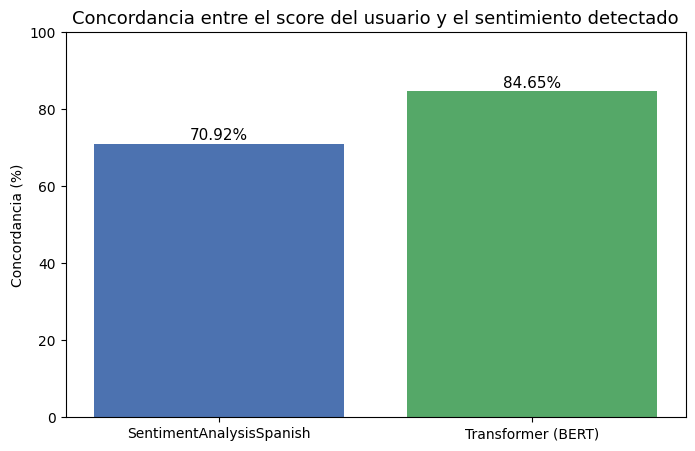

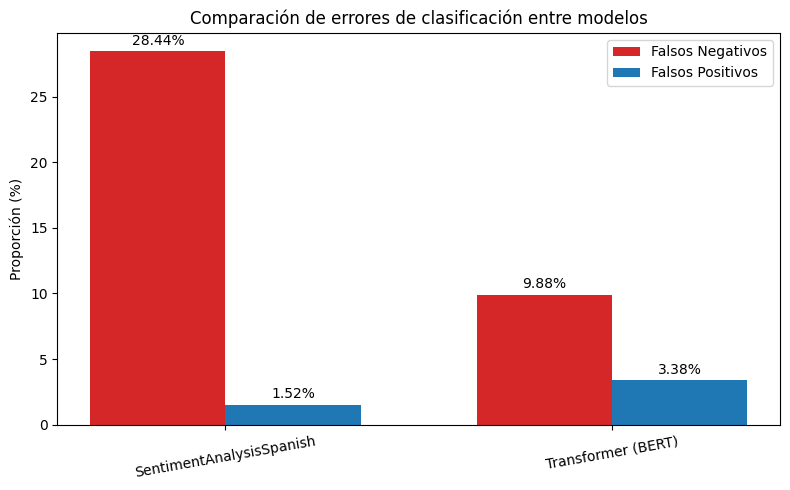


📊 Comparativo general de desempeño entre modelos:


,Modelo,Negativos con score 4-5 (%),Positivos con score 1-2 (%),Concordancia (%)
0,SentimentAnalysisSpanish,28.44,1.52,70.921033
1,Transformer (BERT),9.88,3.38,84.654426


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1️ Crear etiqueta de sentimiento según el score del usuario
df['score_label'] = df['score'].apply(
    lambda x: 'Positivo' if x >= 4 else ('Negativo' if x <= 2 else 'Neutral')
)

# 2️ Calcular la concordancia entre el sentimiento y el score
concordancia_spanish = (df['score_label'] == df['sentimiento_spa']).mean()
concordancia_transformer = (df['score_label'] == df['sentimiento_transformer']).mean()

# 3️ Resumen con proporciones
datos = {
    'Modelo': ['SentimentAnalysisSpanish', 'Transformer (BERT)'],
    'Negativos con score 4-5 (%)': [28.44, 9.88],
    'Positivos con score 1-2 (%)': [1.52, 3.38],
    'Concordancia (%)': [concordancia_spanish * 100, concordancia_transformer * 100]
}

tabla_comparativa = pd.DataFrame(datos)

# === GRÁFICA 1: Concordancia general ===
plt.figure(figsize=(8, 5))
bars = plt.bar(tabla_comparativa['Modelo'], tabla_comparativa['Concordancia (%)'], color=['#4c72b0', '#55a868'])
plt.title('Concordancia entre el score del usuario y el sentimiento detectado', fontsize=13)
plt.ylabel('Concordancia (%)')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', fontsize=11)

plt.show()

# === GRÁFICA 2: Falsos negativos y positivos ===
ancho_barra = 0.35
x = np.arange(len(tabla_comparativa['Modelo']))

fig, ax = plt.subplots(figsize=(8, 5))
b1 = ax.bar(x - ancho_barra/2, tabla_comparativa['Negativos con score 4-5 (%)'], ancho_barra, label='Falsos Negativos', color='#d62728')
b2 = ax.bar(x + ancho_barra/2, tabla_comparativa['Positivos con score 1-2 (%)'], ancho_barra, label='Falsos Positivos', color='#1f77b4')

ax.set_ylabel('Proporción (%)')
ax.set_title('Comparación de errores de clasificación entre modelos')
ax.set_xticks(x)
ax.set_xticklabels(tabla_comparativa['Modelo'], rotation=10)
ax.legend()

for b in b1 + b2:
    yval = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# === Mostrar tabla resumen ===
print("\n📊 Comparativo general de desempeño entre modelos:")
display(tabla_comparativa)



--- 1. Matriz de Confusión (SentimentAnalysisSpanish) ---


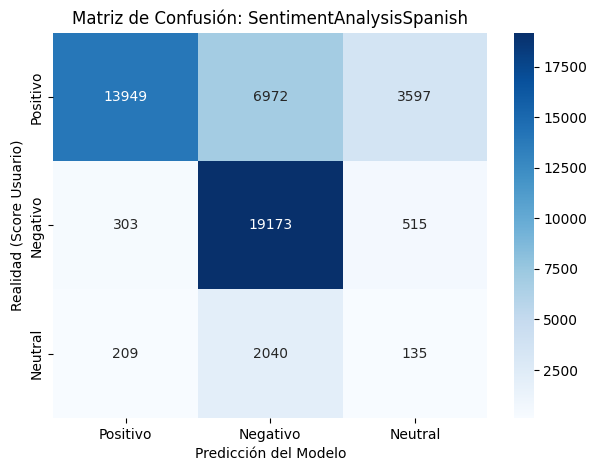


--- 2. Matriz de Confusión (Transformer - BERT) ---


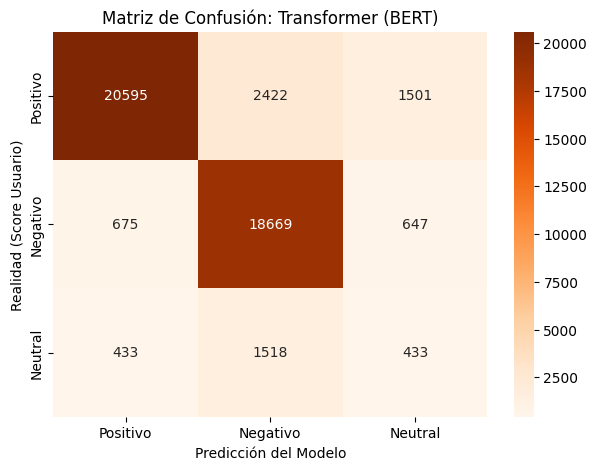



--- Reporte de Clasificación (SentimentAnalysisSpanish) ---
              precision    recall  f1-score   support

    Positivo      0.965     0.569     0.716     24518
    Negativo      0.680     0.959     0.796     19991
     Neutral      0.032     0.057     0.041      2384

    accuracy                          0.709     46893
   macro avg      0.559     0.528     0.517     46893
weighted avg      0.796     0.709     0.716     46893


--- Reporte de Clasificación (Transformer - BERT) ---
              precision    recall  f1-score   support

    Positivo      0.949     0.840     0.891     24518
    Negativo      0.826     0.934     0.876     19991
     Neutral      0.168     0.182     0.174      2384

    accuracy                          0.847     46893
   macro avg      0.647     0.652     0.647     46893
weighted avg      0.857     0.847     0.848     46893



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# --- Preparación ---
# 1. Definir el orden de las etiquetas
# Para que la matriz (Pos, Neg, Neu) se muestre en un orden lógico
# y sea igual para ambos modelos, permitiendo una comparación justa.
labels_order = ['Positivo', 'Negativo', 'Neutral']

# 2. Extraer los datos (Realidad vs. Predicción)
y_real = df['score_label']
y_pred_spa = df['sentimiento_spa']
y_pred_transformer = df['sentimiento_transformer']


# === GRÁFICA 3: Matriz de Confusión - SentimentAnalysisSpanish ===

print("\n--- 1. Matriz de Confusión (SentimentAnalysisSpanish) ---")

# 1. Calcular la Matriz de Confusión
cm_spa = confusion_matrix(y_real, y_pred_spa, labels=labels_order)

# 2. Graficar el Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm_spa,
            annot=True,     # Mostrar los números en cada celda
            fmt='d',        # Formato de los números (enteros)
            cmap='Blues',   # Paleta de colores
            xticklabels=labels_order,
            yticklabels=labels_order)

plt.title('Matriz de Confusión: SentimentAnalysisSpanish')
plt.ylabel('Realidad (Score Usuario)')
plt.xlabel('Predicción del Modelo')
plt.show()


# === GRÁFICA 4: Matriz de Confusión - Transformer (BERT) ===

print("\n--- 2. Matriz de Confusión (Transformer - BERT) ---")

# 1. Calcular la Matriz de Confusión
cm_transformer = confusion_matrix(y_real, y_pred_transformer, labels=labels_order)

# 2. Graficar el Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm_transformer,
            annot=True,
            fmt='d',
            cmap='Oranges', # Usamos otro color para diferenciarlo
            xticklabels=labels_order,
            yticklabels=labels_order)

plt.title('Matriz de Confusión: Transformer (BERT)')
plt.ylabel('Realidad (Score Usuario)')
plt.xlabel('Predicción del Modelo')
plt.show()


# === (Opcional pero recomendado) Reporte de Clasificación ===
# Esto te da la Precisión, Recall y F1-Score para cada clase

print("\n\n--- Reporte de Clasificación (SentimentAnalysisSpanish) ---")
print(classification_report(y_real, y_pred_spa, labels=labels_order, digits=3))

print("\n--- Reporte de Clasificación (Transformer - BERT) ---")
print(classification_report(y_real, y_pred_transformer, labels=labels_order, digits=3))

## Fase 10: Resultados y análisis del sentimiento de las aplicaciones financiereas

--- Generando gráfico de proporciones de sentimiento ---
Orden de apps (de más negativas a menos): ['Powwi', 'Coink', 'Daviplata (Davivienda)', 'Lulo Bank', 'Nubank Colombia', 'Movii', 'Tpaga', 'Dale! (Grupo Aval)', 'Ualá Colombia', 'Addi', 'Nequi (Bancolombia)']


/tmp/ipython-input-3054471128.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


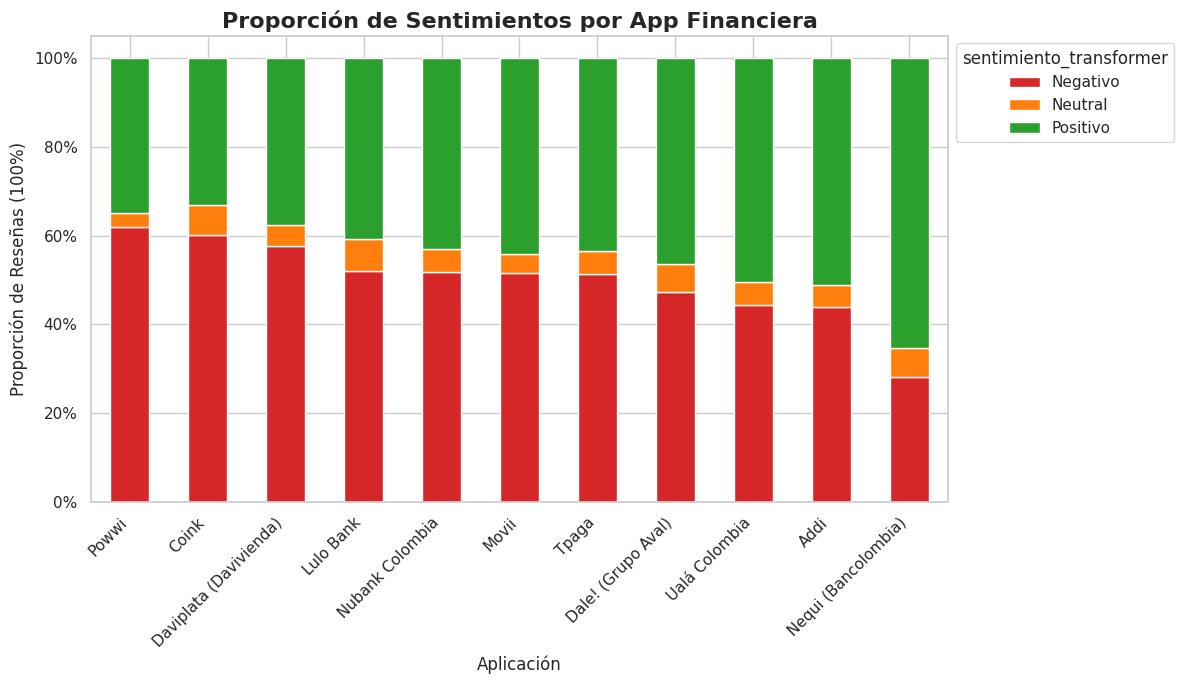


--- Tabla de Proporciones (para referencia) ---
sentimiento_transformer  Negativo  Neutral  Positivo
nombre_app                                          
Powwi                       61.85     3.14     35.01
Coink                       60.11     6.77     33.12
Daviplata (Davivienda)      57.60     4.73     37.67
Lulo Bank                   52.11     7.14     40.75
Nubank Colombia             51.73     5.33     42.94
Movii                       51.68     4.27     44.05
Tpaga                       51.27     5.19     43.55
Dale! (Grupo Aval)          47.21     6.44     46.35
Ualá Colombia               44.44     5.12     50.43
Addi                        44.00     4.93     51.08
Nequi (Bancolombia)         28.14     6.63     65.23


In [ ]:
print("--- Generando gráfico de proporciones de sentimiento ---")

# --- 1. Preparar los datos para ordenar ---
# calcular el porcentaje de 'Negativo' para cada app.

# 1a. Contar los sentimientos por app
df_counts = df.groupby('nombre_app')['sentimiento_transformer'].value_counts()

# 1b. Calcular el total de reseñas por app
df_total = df.groupby('nombre_app')['sentimiento_transformer'].count()

# 1c. Calcular la proporción de cada sentimiento
df_proportions = (df_counts / df_total).unstack(fill_value=0)

# 1d. Obtener el order para el gráfico:
# Ordenamos las apps por 'Negativo' de mayor a menor.
if 'Negativo' in df_proportions.columns:
    order_apps = df_proportions.sort_values(by='Negativo', ascending=False).index.tolist() # Convert to list
else:
    print("Advertencia: No se encontraron reseñas 'Negativo' para ordenar.")
    order_apps = df_proportions.index.tolist() # Convert to list (Order by default)


print("Orden de apps (de más negativas a menos):", order_apps)


# --- 2. Configurar el estilo del gráfico ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))


# --- 3. Graficar usando pandas plot (Stacked Bar) ---

# Reorder the dataframe based on the order_apps list
df_proportions_ordered = df_proportions.reindex(order_apps)

# Define colors for the sentiments
colors = {'Positivo':'#2ca02c', 'Negativo':'#d62728', 'Neutral':'#ff7f0e'}
# Ensure columns are in a desired order for stacking (e.g., Negativo, Neutral, Positivo)
column_order = ['Negativo', 'Neutral', 'Positivo']
# Filter columns to include only those present in df_proportions_ordered
columns_to_plot = [col for col in column_order if col in df_proportions_ordered.columns]


ax = df_proportions_ordered[columns_to_plot].plot(kind='bar', stacked=True, color=[colors[col] for col in columns_to_plot], ax=plt.gca())


# --- 4. Ajustes y limpieza del gráfico ---
ax.set_title('Proporción de Sentimientos por App Financiera', fontsize=16, weight='bold')
ax.set_ylabel('Proporción de Reseñas (100%)')
ax.set_xlabel('Aplicación')

# Ajusta las etiquetas del eje Y para mostrar porcentajes
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])

# Rota etiquetas del eje X si son muchas apps
plt.xticks(rotation=45, ha='right')

# Mover la leyenda fuera del gráfico
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# --- 5. Mostrar la tabla de proporciones ---
print("\n--- Tabla de Proporciones (para referencia) ---")
# Multiplicamos por 100 y redondeamos
print(df_proportions.mul(100).round(2).sort_values(by='Negativo', ascending=False))